In [41]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
import datetime
import pandas as pd
import numpy as np
from functools import partial
from dateutil import parser as dtparser

from utils.datafetch import *
from utils.vectorized_funs import *
from utils.datapipe import *
from utils.kerasutil import *
from FintechCapstone import FinCapstone

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from __future__ import print_function


In [45]:
%matplotlib inline

plt.style.use('seaborn-whitegrid')
date_from = '2009-01-01'
date_to = '2017-03-01'
timespan = {
    "short_term": [1, 5]
    ,"medium_term": [40]
    ,"long_term": [90]
}

timespan_ab = {
    "short_term": []
    ,"medium_term": [30]
    ,"long_term": []
}

trial = FinCapstone(ticker_list=["ZHNE","BSFT","AERO","MATR","ITMSF","FIT","TIPT","OLBK","QADA","ATTU","LGF","STX","TPCS","GSAT","ZNGA","GLW","HIMX","YHOO", "NWSA","JAKK","GLUU","AMZN", "AAPL", "EBAY", "GOOG", "DIS", "NFLX", "EA", "TWTR", "FB", "TTWO", "PXLW", "UBI"], ticker_list_samplesize=4, timespan=timespan, timespan_ab=timespan_ab, date_from=date_from)
#trial = FinCapstone(ticker_list_samplesize=200, timespan=timespan, timespan_ab=timespan_ab, date_from=date_from)

trial.run_initial_dataload()
trial.feature_engineering(feature_set="triala")

(1/33) Recv. and Stored ZHNE
(2/33) Recv. and Stored BSFT
(3/33) Recv. and Stored AERO
(4/33) ERROR receiving MATR
(5/33) Recv. and Stored ITMSF
(6/33) Recv. and Stored FIT
(7/33) Recv. and Stored TIPT
(8/33) Recv. and Stored OLBK
(9/33) Recv. and Stored QADA
(10/33) Recv. and Stored ATTU
(11/33) Recv. and Stored LGF
(12/33) Recv. and Stored STX
(13/33) Recv. and Stored TPCS
(14/33) Recv. and Stored GSAT
(15/33) Recv. and Stored ZNGA
(16/33) Recv. and Stored GLW
(17/33) Recv. and Stored HIMX
(18/33) Recv. and Stored YHOO
(19/33) Recv. and Stored NWSA
(20/33) Recv. and Stored JAKK
(21/33) Recv. and Stored GLUU
(22/33) Recv. and Stored AMZN
(23/33) Recv. and Stored AAPL
(24/33) Recv. and Stored EBAY
(25/33) Recv. and Stored GOOG
(26/33) Recv. and Stored DIS
(27/33) Recv. and Stored NFLX
(28/33) Recv. and Stored EA
(29/33) Recv. and Stored TWTR
(30/33) Recv. and Stored FB
(31/33) Recv. and Stored TTWO
(32/33) Recv. and Stored PXLW
(33/33) Recv. and Stored UBI
Took 0:00:09.057524


 - ZHNE

/home/jovyan/work/FintechCapstone/utils/vectorized_funs.py:785: RuntimeWarning: divide by zero encountered in true_divide
  pdi = (pdm_ema14 / atr) * 100.0
/home/jovyan/work/FintechCapstone/utils/vectorized_funs.py:785: RuntimeWarning: invalid value encountered in true_divide
  pdi = (pdm_ema14 / atr) * 100.0
/home/jovyan/work/FintechCapstone/utils/vectorized_funs.py:786: RuntimeWarning: invalid value encountered in true_divide
  ndi = (ndm_ema14 / atr) * 100.0


\ / AROON - 0:00:01.827537
\ / CMFLOW - 0:00:00.004481
\ / OBV - 0:00:00.003993
\ / RETURNS - 0:00:00.157650
 V  END       - 2017-04-16 19:51:14.723500 (TOOK 0:00:02.051263)


 - ITMSF - 

| | START     - 2017-04-16 19:51:14.761686
\ / SMAs - 0:00:00.005329
\ / BOLLINGER - 0:00:00.013991
\ / MACD - 0:00:00.001844
\ / RSI - 0:00:00.017080
\ / OSCILATOR - 0:00:00.004030
\ / ADX - 0:00:00.011216
\ / AROON - 0:00:01.672572
\ / CMFLOW - 0:00:00.004589
\ / OBV - 0:00:00.004232
\ / RETURNS - 0:00:00.151867
 V  END       - 2017-04-16 19:51:16.648518 (TOOK 0:00:01.886832)


 - FIT - 

| | START     - 2017-04-16 19:51:16.682240
\ / SMAs - 0:00:00.004969
\ / BOLLINGER - 0:00:00.015132
\ / MACD - 0:00:00.002117
\ / RSI - 0:00:00.006161
\ / OSCILATOR - 0:00:00.004008
\ / ADX - 0:00:00.011472
\ / AROON - 0:00:00.418188
\ / CMFLOW - 0:00:00.004284
\ / OBV - 0:00:00.004059
\ / RETURNS - 0:00:00.046538
 V  END       - 2017-04-16 19:51:17.199226 (TOOK 0:00:00.516986)


 - TIPT - 

| | START     - 2017-0

/home/jovyan/work/FintechCapstone/utils/vectorized_funs.py:788: RuntimeWarning: divide by zero encountered in true_divide
  adx = 100.0 * ExpMovingAverage(np.abs((pdi - ndi)), 14) / (pdi + ndi)


\ / AROON - 0:00:01.607377
\ / CMFLOW - 0:00:00.004973
\ / OBV - 0:00:00.004330
\ / RETURNS - 0:00:00.141958
 V  END       - 2017-04-16 19:51:19.035860 (TOOK 0:00:01.815379)


 - OLBK - 

| | START     - 2017-04-16 19:51:19.077230
\ / SMAs - 0:00:00.005584
\ / BOLLINGER - 0:00:00.016249
\ / MACD - 0:00:00.002254
\ / RSI - 0:00:00.022295
\ / OSCILATOR - 0:00:00.004440
\ / ADX - 0:00:00.012299
\ / AROON - 0:00:01.802363
\ / CMFLOW - 0:00:00.004258
\ / OBV - 0:00:00.004284
\ / RETURNS - 0:00:00.159851
 V  END       - 2017-04-16 19:51:21.111183 (TOOK 0:00:02.033953)


 - QADA - 

| | START     - 2017-04-16 19:51:21.152115
\ / SMAs - 0:00:00.005146
\ / BOLLINGER - 0:00:00.013435
\ / MACD - 0:00:00.001845
\ / RSI - 0:00:00.015320
\ / OSCILATOR - 0:00:00.003929
\ / ADX - 0:00:00.010956
\ / AROON - 0:00:01.346121
\ / CMFLOW - 0:00:00.004186
\ / OBV - 0:00:00.003876
\ / RETURNS - 0:00:00.132142
 V  END       - 2017-04-16 19:51:22.689148 (TOOK 0:00:01.537033)


 - ATTU - 

| | START     - 2017-0

/home/jovyan/work/FintechCapstone/utils/vectorized_funs.py:786: RuntimeWarning: divide by zero encountered in true_divide
  ndi = (ndm_ema14 / atr) * 100.0


\ / AROON - 0:00:02.048680
\ / CMFLOW - 0:00:00.004651
\ / OBV - 0:00:00.004285
\ / RETURNS - 0:00:00.184262
 V  END       - 2017-04-16 19:51:31.435981 (TOOK 0:00:02.304566)


 - GSAT - 

| | START     - 2017-04-16 19:51:31.475988
\ / SMAs - 0:00:00.005178
\ / BOLLINGER - 0:00:00.014970
\ / MACD - 0:00:00.003012
\ / RSI - 0:00:00.012037
\ / OSCILATOR - 0:00:00.005036
\ / ADX - 0:00:00.016041
\ / AROON - 0:00:00.770003
\ / CMFLOW - 0:00:00.004454
\ / OBV - 0:00:00.004144
\ / RETURNS - 0:00:00.071249
 V  END       - 2017-04-16 19:51:32.382183 (TOOK 0:00:00.906195)


 - ZNGA - 

| | START     - 2017-04-16 19:51:32.406667
\ / SMAs - 0:00:00.005348
\ / BOLLINGER - 0:00:00.014553
\ / MACD - 0:00:00.001982
\ / RSI - 0:00:00.014589
\ / OSCILATOR - 0:00:00.004236
\ / ADX - 0:00:00.012284
\ / AROON - 0:00:01.306379
\ / CMFLOW - 0:00:00.004752
\ / OBV - 0:00:00.004314
\ / RETURNS - 0:00:00.120762
 V  END       - 2017-04-16 19:51:33.895940 (TOOK 0:00:01.489273)


 - GLW - 

| | START     - 2017-04

/home/jovyan/work/FintechCapstone/utils/vectorized_funs.py:705: RuntimeWarning: divide by zero encountered in double_scalars
  rs = up/down
/home/jovyan/work/FintechCapstone/utils/vectorized_funs.py:721: RuntimeWarning: divide by zero encountered in double_scalars
  rs = up/down


\ / AROON - 0:00:00.391692
\ / CMFLOW - 0:00:00.004132
\ / OBV - 0:00:00.003801
\ / RETURNS - 0:00:00.037933
 V  END       - 2017-04-16 19:52:09.486180 (TOOK 0:00:00.478977)


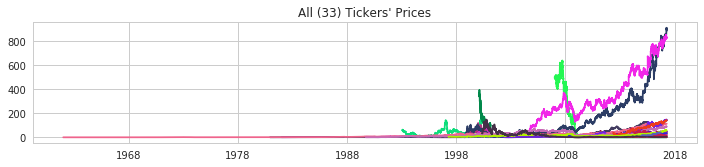

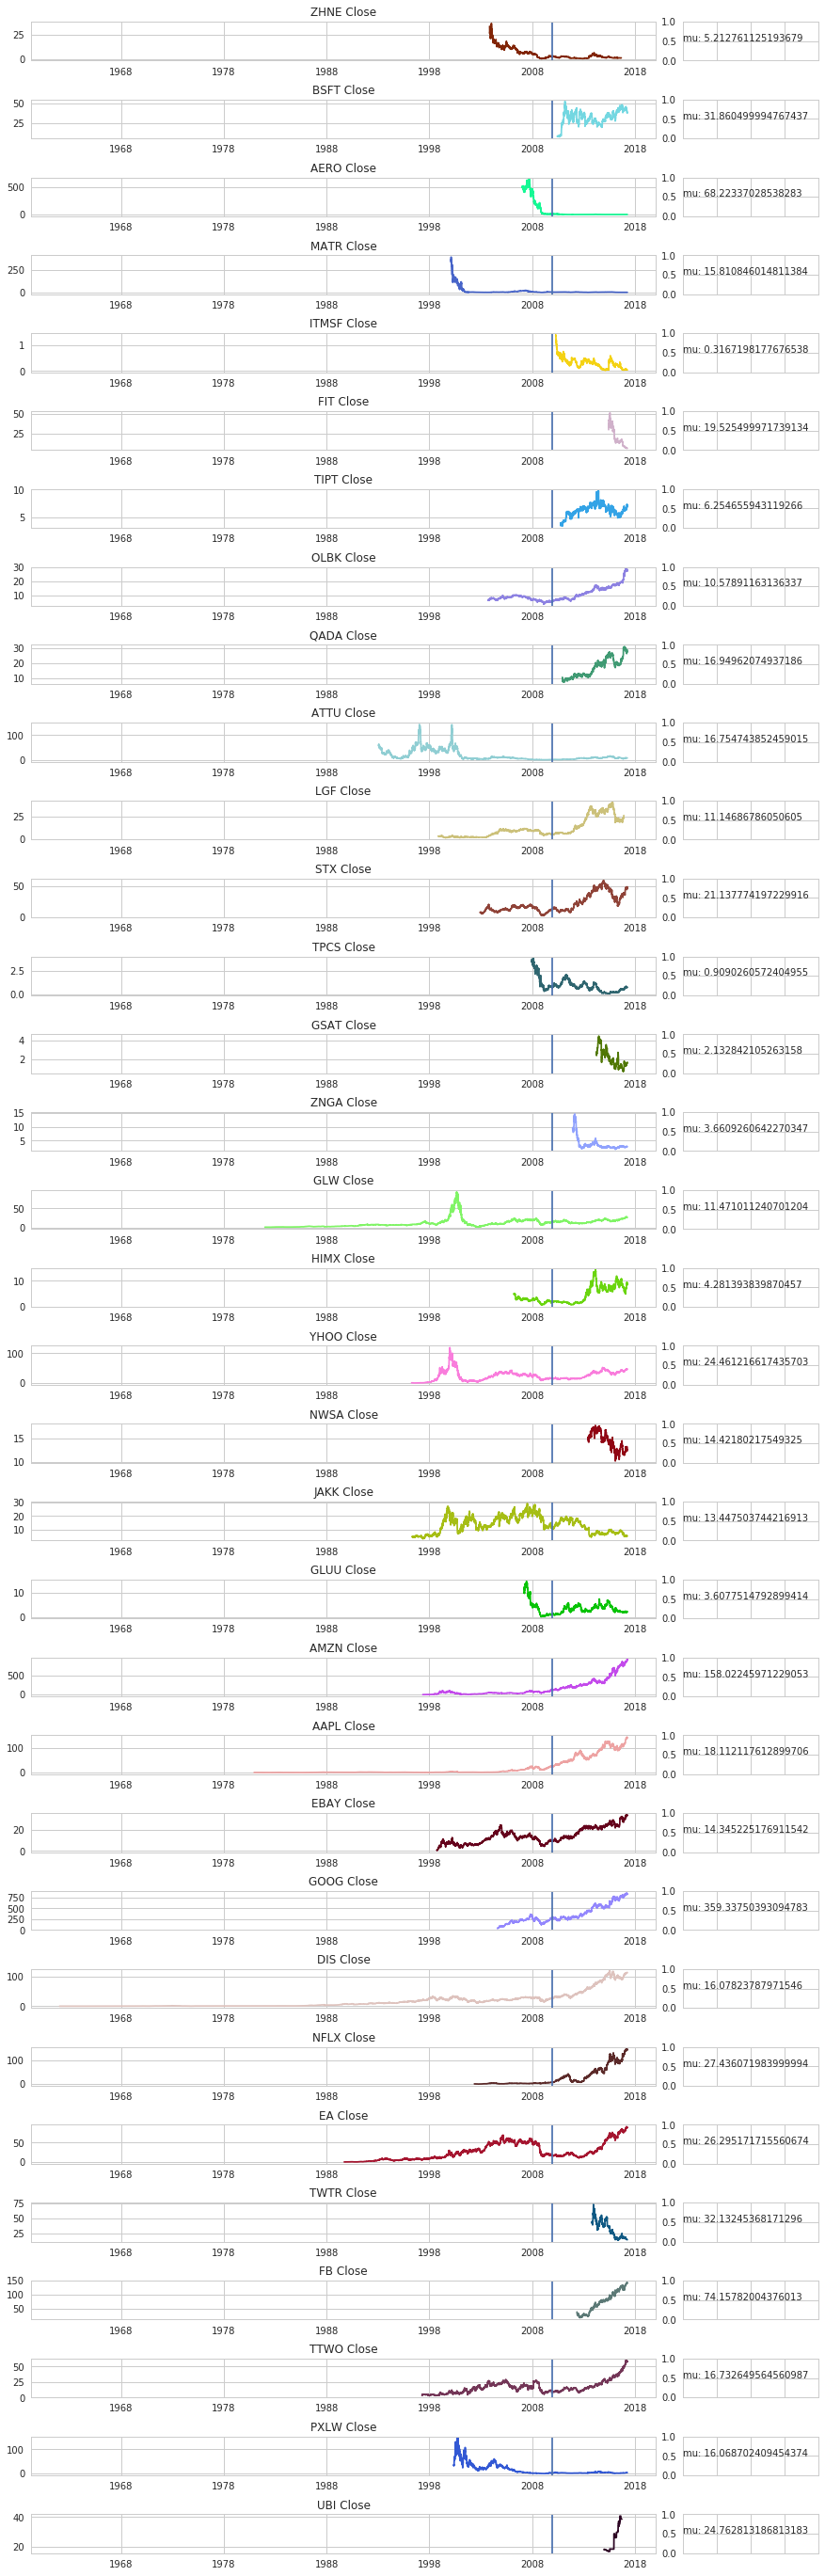

In [44]:
def plot_allprices(ticker_list):
    
    ## Setup our image
    fig = plt.figure(figsize=(15, 3))
    grid = plt.GridSpec(4, 5, hspace=0.2, wspace=0.2)
    
    
    main_ax = fig.add_subplot(grid[:-1, :4])

    main_ax.set_title("All ({}) Tickers' Prices".format(ticker_list.shape[0]))
    for itr_ticker in ticker_list:
        #Load Dataframes with the raw prices
        raw_df = load_raw_frame(itr_ticker, tryfetch=True, dropAdjClose=True)
        raw_df.set_index("Date", inplace=True)
        
        x = raw_df.index.tolist()
        
        #Plot close price
        main_ax.plot(x, raw_df["Close"], '-g', label="Close", c=np.random.rand(3,1))


    plt.show()

def plot_allprices_list(ticker_list):
    
    ## Setup our image
    fig = plt.figure(figsize=(15, 1.5*ticker_list.shape[0]))
    grid = plt.GridSpec(ticker_list.shape[0], 5, hspace=1, wspace=0.2)
    ax = []
    summary = []
    
    for idx_ticker, itr_ticker in enumerate(ticker_list):
        ax.append(fig.add_subplot(grid[idx_ticker, :4], sharex=(None if idx_ticker == 0 else ax[0])))
        summary.append(fig.add_subplot(grid[idx_ticker, 4]))
    
    for idx_ticker, itr_ticker in enumerate(ticker_list):
        #Load Dataframes with the raw prices
        raw_df = load_raw_frame(itr_ticker, tryfetch=True, dropAdjClose=True)
        raw_df.set_index("Date", inplace=True)
        
        x = raw_df.index.tolist()
        
        #Plot close price
        ax[idx_ticker].plot(x, raw_df["Close"], '-g', label="Close", c=np.random.rand(3,1))
        ax[idx_ticker].set_title("{} Close".format(itr_ticker))
        
        ax[idx_ticker].axvline(x='2010-01-01')
        
        summary[idx_ticker].text(0,0.5, 'mu: {}'.format(raw_df["Close"].mean()))
        summary[idx_ticker].tick_params(
            axis='both',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            left='off',      # ticks along the bottom edge are off
            right='off',         # ticks along the top edge are of
            labelbottom='off') # labels along the bottom edge are off        


    plt.show()

plot_allprices(trial.valid_ticker_list())
plot_allprices_list(trial.valid_ticker_list()[:])

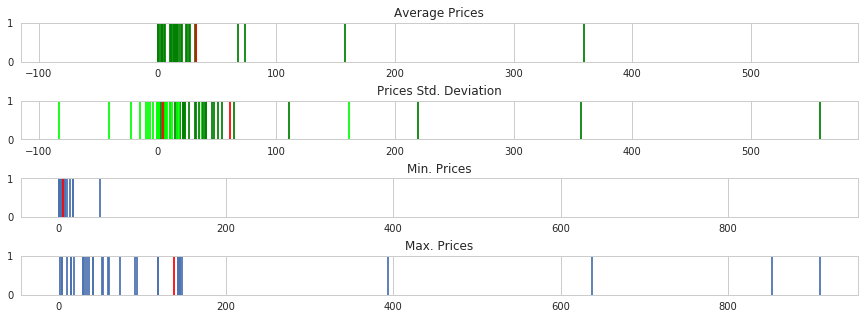

In [62]:
def plot_pricedist(ticker_list):
    _tickers = dict()
    _pnl = None
    
    ## Setup our image
    fig = plt.figure(figsize=(15, 5))
    grid = plt.GridSpec(4, 4, hspace=1, wspace=0.2)
    
    mean_ax = fig.add_subplot(grid[0, :])
    std_ax = fig.add_subplot(grid[1, :], sharex=mean_ax)
    min_ax = fig.add_subplot(grid[2, :])
    max_ax = fig.add_subplot(grid[3, :], sharex=min_ax)
    
    mean_ax.set_title("Average Prices")
    std_ax.set_title("Prices Std. Deviation")
    min_ax.set_title("Min. Prices")
    max_ax.set_title("Max. Prices")

    
    for itr_ticker in ticker_list:
        #Load Dataframes with the raw prices
        raw_df = load_raw_frame(itr_ticker, tryfetch=True, parseDate=True, dropAdjClose=True)
        raw_df.set_index("Date", inplace=True)
        
        mean_ax.axvline(x=raw_df["Close"].mean(), color="green")
        std_ax.axvline(x=raw_df["Close"].mean() + raw_df["Close"].std(), color="green")
        std_ax.axvline(x=raw_df["Close"].mean() - raw_df["Close"].std(), color="lime")
        min_ax.axvline(x=raw_df["Close"].min())
        max_ax.axvline(x=raw_df["Close"].max())
        
        _tickers[itr_ticker] = raw_df.describe()
    
    _pnl = pd.Panel(_tickers)
    
    
    mean_ax.axvline(x=_pnl[:,"mean","Close"].mean(), color="red")
    std_ax.axvline(x=_pnl[:,"mean","Close"].mean() - _pnl[:,"std","Close"].mean(), color="red")
    std_ax.axvline(x=_pnl[:,"mean","Close"].mean() + _pnl[:,"std","Close"].mean(), color="red")
    min_ax.axvline(x=_pnl[:,"min", "Close"].mean(), color="red")
    max_ax.axvline(x=_pnl[:,"max", "Close"].mean(), color="red")


    plt.show()

plot_pricedist(trial.valid_ticker_list()[:])

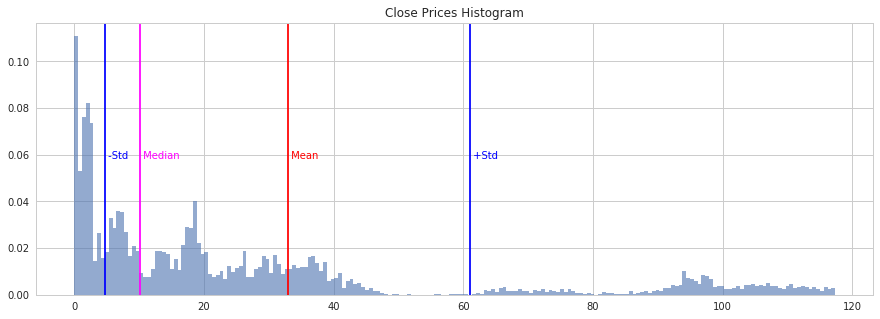

In [178]:
scale = 3
_tickers = dict()
_data = dict()


## Iterate all tickers to read stats and prices
for itr_ticker in trial.valid_ticker_list():
    raw_df = load_raw_frame(itr_ticker, parseDate=True, dropAdjClose=True)
    raw_df.set_index("Date", inplace=True)
    
    ##Store Stats
    _tickers[itr_ticker] = raw_df.describe()
    ##Store Prices and Volume
    _data[itr_ticker] = raw_df.loc[:, ["Close", "Volume"]]


##Convert into DataPanels
_stats = pd.Panel(_tickers)
_pnl = pd.Panel(_data)


mu = _stats[:,"mean","Close"].mean()
std = _stats[:,"std","Close"].mean()
mode = _stats[:,"std","Close"].mode()
median = _stats[:,"std","Close"].median()


#Create Bin range from [-std, +std] with centered mean
bins = np.linspace(max(mu - scale*std, 0), mu + scale*std, 200)

## Setup our image
fig = plt.figure(figsize=(15, 5))
grid = plt.GridSpec(4, 4, hspace=1, wspace=0.2)


#Close Ploting
ax = fig.add_subplot(grid[0:, :])

kwargs = dict(histtype='stepfilled', alpha=0.6, normed=True, bins=bins)

ax.set_title("{} Prices Histogram".format("Close"))
ax.hist(_pnl[:,:,"Close"].dropna().values.flatten(), **kwargs)

#Mark descriptive stats
ax.axvline(mu, color="red")
ax.axvline(mu-std, color="blue")
ax.axvline(mu+std, color="blue")
ax.axvline(median, color="magenta")

#Annotate descriptive stats
ax.text(mu,     (0.5 * ax.get_ylim()[1]), " Mean", color="red")
ax.text(mu-std, (0.5 * ax.get_ylim()[1]), " -Std", color="blue")
ax.text(mu+std, (0.5 * ax.get_ylim()[1]), " +Std", color="blue")
ax.text(median, (0.5 * ax.get_ylim()[1]), " Median", color="magenta")

plt.show()



In [5]:
def calc_triala(raw_df):
    trial_a = pd.DataFrame()
    trial_a["SMA_5"] = raw_df["Close"].rolling(window=5).mean()
    trial_a["SMA_30"] = raw_df["Close"].rolling(window=30).mean()
    trial_a["SMA_60"] = raw_df["Close"].rolling(window=60).mean()
    trial_a["SMA_200"] = raw_df["Close"].rolling(window=200).mean()

    trial_a["BOLL_5_UP"] = trial_a["SMA_5"] + (2 * raw_df["Close"].rolling(window=5).std())
    trial_a["BOLL_5_DOWN"] = trial_a["SMA_5"] - (2 * raw_df["Close"].rolling(window=5).std())
    trial_a["BOLL_30_UP"] = trial_a["SMA_30"] + (2 * raw_df["Close"].rolling(window=30).std())
    trial_a["BOLL_30_DOWN"] = trial_a["SMA_30"] - (2 * raw_df["Close"].rolling(window=30).std())
    trial_a["BOLL_60_UP"] = trial_a["SMA_60"] + (2 * raw_df["Close"].rolling(window=60).std())
    trial_a["BOLL_60_DOWN"] = trial_a["SMA_60"] - (2 * raw_df["Close"].rolling(window=60).std())
    trial_a["BOLL_200_UP"] = trial_a["SMA_200"] + (2 * raw_df["Close"].rolling(window=200).std())
    trial_a["BOLL_200_DOWN"] = trial_a["SMA_200"] - (2 * raw_df["Close"].rolling(window=200).std())


    emaslow, emafast, macd = calc_macd(raw_df["Close"], 26, 12)
    trial_a["MACD"] = macd
    trial_a["MACD_EMASLOW"] = emaslow
    trial_a["MACD_EMAFAST"] = emafast


    trial_a["RSI_14"] = rsiFunc(raw_df["Close"], 14)
    trial_a["RSI_21"] = rsiFunc(raw_df["Close"], 21)
    trial_a["RSI_60"] = rsiFunc(raw_df["Close"], 60)


    trial_a["STOCOSCILATOR_14"] = calc_stochasticoscilator(raw_df, 14)
    trial_a["STOCOSCILATOR_14_SMA"] = trial_a["STOCOSCILATOR_14"].rolling(window=3).mean()


    adx, pdi, ndi = calc_adx(raw_df)
    trial_a["ADX"] = adx
    trial_a["ADX_PDI"] = pdi
    trial_a["ADX_NDI"] = ndi


    aroon_up, aroon_down = calc_aroon(raw_df, 20)
    trial_a["AROONUP_20"] = aroon_up.values
    trial_a["AROONDOWN_20"] = aroon_down.values


    cmf, dmf = calc_chaikin_money_flow(raw_df, window=21)
    trial_a["CHAIKIN_MFLOW_21"] = cmf
    trial_a["DAILY_MFLOW_21"] = dmf

    trial_a["RETURN_1"] = ((raw_df["Close"] / raw_df["Close"].shift(1)) - 1)
    trial_a["RETURN_30"] = ((raw_df["Close"] / raw_df["Close"].shift(30)) - 1)
    trial_a["RETURN_60"] = ((raw_df["Close"] / raw_df["Close"].shift(60)) - 1)
    trial_a["RETURN_200"] = ((raw_df["Close"] / raw_df["Close"].shift(200)) - 1)

    trial_a["OBV"] = onbalancevolumeFunc(trial_a["RETURN_1"], raw_df["Volume"])
    
    return trial_a


In [6]:
_triala = dict()

for idx_ticker, itr_ticker in enumerate(trial.valid_ticker_list()):
    print(itr_ticker)
    raw_df = load_raw_frame(itr_ticker, parseDate=True, dropAdjClose=True)
    raw_df.set_index("Date", inplace=True)
    trial_a = calc_triala(raw_df)
    
    trial_a.set_index(raw_df.index.copy(), inplace=True)
    
    _triala[itr_ticker] = trial_a.loc[dtparser.parse(trial.date_from):dtparser.parse(trial.date_to)]

    del raw_df
    del trial_a


_pnl = pd.Panel(_triala)

del _triala

_pnl

ZHNE
BSFT
AERO


/home/jovyan/work/FintechCapstone/utils/vectorized_funs.py:785: RuntimeWarning: divide by zero encountered in true_divide
  pdi = (pdm_ema14 / atr) * 100.0
/home/jovyan/work/FintechCapstone/utils/vectorized_funs.py:785: RuntimeWarning: invalid value encountered in true_divide
  pdi = (pdm_ema14 / atr) * 100.0
/home/jovyan/work/FintechCapstone/utils/vectorized_funs.py:786: RuntimeWarning: invalid value encountered in true_divide
  ndi = (ndm_ema14 / atr) * 100.0


MATR
ITMSF
FIT
TIPT


/home/jovyan/work/FintechCapstone/utils/vectorized_funs.py:788: RuntimeWarning: divide by zero encountered in true_divide
  adx = 100.0 * ExpMovingAverage(np.abs((pdi - ndi)), 14) / (pdi + ndi)


OLBK
QADA
ATTU
LGF
STX
TPCS


/home/jovyan/work/FintechCapstone/utils/vectorized_funs.py:786: RuntimeWarning: divide by zero encountered in true_divide
  ndi = (ndm_ema14 / atr) * 100.0


GSAT
ZNGA
GLW
HIMX
YHOO
NWSA
JAKK
GLUU
AMZN
AAPL
EBAY
GOOG
DIS
NFLX
EA
TWTR
FB
TTWO


/home/jovyan/work/FintechCapstone/utils/vectorized_funs.py:788: RuntimeWarning: invalid value encountered in subtract
  adx = 100.0 * ExpMovingAverage(np.abs((pdi - ndi)), 14) / (pdi + ndi)


PXLW
UBI


/home/jovyan/work/FintechCapstone/utils/vectorized_funs.py:705: RuntimeWarning: divide by zero encountered in double_scalars
  rs = up/down
/home/jovyan/work/FintechCapstone/utils/vectorized_funs.py:721: RuntimeWarning: divide by zero encountered in double_scalars
  rs = up/down


<class 'pandas.core.panel.Panel'>
Dimensions: 33 (items) x 2100 (major_axis) x 32 (minor_axis)
Items axis: AAPL to ZNGA
Major_axis axis: 2009-01-02 00:00:00 to 2017-04-13 00:00:00
Minor_axis axis: SMA_5 to OBV

In [48]:
a = trial.load_triala_features("GLUU", True)
a

,Date,SMA_5,SMA_30,SMA_60,SMA_200,BOLL_5_UP,BOLL_5_DOWN,BOLL_30_UP,BOLL_30_DOWN,BOLL_60_UP,...,STOCOSCILATOR_14,STOCOSCILATOR_14_SMA,ADX,ADX_PDI,ADX_NDI,AROONUP_20,AROONDOWN_20,CHAIKIN_MFLOW_21,DAILY_MFLOW_21,OBV
0,2009-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.975366,-24.026597,-24.499908,NaN,NaN,NaN,-5.620000e+04,-56200.0
1,2009-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.975366,-24.026597,-24.499908,NaN,NaN,NaN,0.000000e+00,-36000.0
2,2009-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.975366,-24.026597,-24.499908,NaN,NaN,NaN,1.802280e+05,159900.0
3,2009-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.975366,-24.026597,-24.499908,NaN,NaN,NaN,-6.592727e+04,56300.0
4,2009-01-08,0.630,NaN,NaN,NaN,0.881396,0.378604,NaN,NaN,NaN,...,NaN,NaN,-0.975366,-24.026597,-24.499908,NaN,NaN,NaN,-2.910000e+04,85400.0
5,2009-01-09,0.694,NaN,NaN,NaN,0.929627,0.458373,NaN,NaN,NaN,...,NaN,NaN,-0.975366,-24.026597,-24.499908,NaN,NaN,NaN,1.740000e+05,282600.0
6,2009-01-12,0.756,NaN,NaN,NaN,0.866091,0.645909,NaN,NaN,NaN,...,NaN,NaN,-0.975366,-24.026597,-24.499908,NaN,NaN,NaN,3.108000e+04,438000.0
7,2009-01-13,0.768,NaN,NaN,NaN,0.892419,0.643581,NaN,NaN,NaN,...,NaN,NaN,-0.975366,-24.026597,-24.499908,NaN,NaN,NaN,-6.176000e+04,592400.0
8,2009-01-14,0.786,NaN,NaN,NaN,0.884590,0.687410,NaN,NaN,NaN,...,NaN,NaN,-0.975366,-24.026597,-24.499908,NaN,NaN,NaN,-2.886154e+04,538800.0
9,2009-01-15,0.778,NaN,NaN,NaN,0.911716,0.644284,NaN,NaN,NaN,...,NaN,NaN,-0.975366,-24.026597,-24.499908,NaN,NaN,NaN,-2.013000e+05,337500.0


In [37]:
raw_df = load_raw_frame("GLUU", parseDate=True, dropAdjClose=True)
raw_df.set_index("Date", inplace=True)
raw_df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2007-03-22,11.50,13.30,11.50,12.29,5237800
2007-03-23,12.32,12.50,10.75,11.51,1870300
2007-03-26,11.50,11.90,11.26,11.69,753300
2007-03-27,11.84,11.84,11.32,11.50,252800
2007-03-28,11.75,11.75,10.75,11.05,155700


In [38]:
ta = trial.calc_triala_features(raw_df, True)

| | START     - 2017-04-16 19:48:03.935723
\ / SMAs - 0:00:00.029240
\ / BOLLINGER - 0:00:00.017061
\ / MACD - 0:00:00.002836
\ / RSI - 0:00:00.025415
\ / OSCILATOR - 0:00:00.004897
\ / ADX - 0:00:00.030550
\ / AROON - 0:00:02.330113
\ / CMFLOW - 0:00:00.004616
\ / OBV - 0:00:00.004068


In [39]:
ta.head()

,SMA_5,SMA_30,SMA_60,SMA_200,BOLL_5_UP,BOLL_5_DOWN,BOLL_30_UP,BOLL_30_DOWN,BOLL_60_UP,BOLL_60_DOWN,...,STOCOSCILATOR_14,STOCOSCILATOR_14_SMA,ADX,ADX_PDI,ADX_NDI,AROONUP_20,AROONDOWN_20,CHAIKIN_MFLOW_21,DAILY_MFLOW_21,OBV
Date,,,,,,,,,,,,,,,,,,,,,
2007-03-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-58.550069,-44.915778,-11.742384,NaN,NaN,NaN,-640175.555556,-5237800.0
2007-03-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-58.550069,-44.915778,-11.742384,NaN,NaN,NaN,-245810.857143,-7108100.0
2007-03-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-58.550069,-44.915778,-11.742384,NaN,NaN,NaN,258946.875000,-6354800.0
2007-03-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-58.550069,-44.915778,-11.742384,NaN,NaN,NaN,-77784.615385,-6607600.0
2007-03-28,11.608,NaN,NaN,NaN,12.504928,10.711072,NaN,NaN,NaN,NaN,...,NaN,NaN,-58.550069,-44.915778,-11.742384,NaN,NaN,NaN,-62280.000000,-6763300.0


In [40]:
ta.to_csv("TESTE.csv", index=True, index_label="Date")
pd.read_csv("TESTE.csv")

,Date,SMA_5,SMA_30,SMA_60,SMA_200,BOLL_5_UP,BOLL_5_DOWN,BOLL_30_UP,BOLL_30_DOWN,BOLL_60_UP,...,STOCOSCILATOR_14,STOCOSCILATOR_14_SMA,ADX,ADX_PDI,ADX_NDI,AROONUP_20,AROONDOWN_20,CHAIKIN_MFLOW_21,DAILY_MFLOW_21,OBV
0,2007-03-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-58.550069,-44.915778,-11.742384,NaN,NaN,NaN,-6.401756e+05,-5237800.0
1,2007-03-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-58.550069,-44.915778,-11.742384,NaN,NaN,NaN,-2.458109e+05,-7108100.0
2,2007-03-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-58.550069,-44.915778,-11.742384,NaN,NaN,NaN,2.589469e+05,-6354800.0
3,2007-03-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-58.550069,-44.915778,-11.742384,NaN,NaN,NaN,-7.778462e+04,-6607600.0
4,2007-03-28,11.608,NaN,NaN,NaN,12.504928,10.711072,NaN,NaN,NaN,...,NaN,NaN,-58.550069,-44.915778,-11.742384,NaN,NaN,NaN,-6.228000e+04,-6763300.0
5,2007-03-29,11.212,NaN,NaN,NaN,12.325589,10.098411,NaN,NaN,NaN,...,NaN,NaN,-58.550069,-44.915778,-11.742384,NaN,NaN,NaN,-1.922560e+05,-7174200.0
6,2007-03-30,10.910,NaN,NaN,NaN,12.381122,9.438878,NaN,NaN,NaN,...,NaN,NaN,-58.550069,-44.915778,-11.742384,NaN,NaN,NaN,-2.858824e+04,-7271400.0
7,2007-04-02,10.578,NaN,NaN,NaN,11.911822,9.244178,NaN,NaN,NaN,...,NaN,NaN,-58.550069,-44.915778,-11.742384,NaN,NaN,NaN,-2.051200e+05,-7015000.0
8,2007-04-03,10.276,NaN,NaN,NaN,11.180831,9.371169,NaN,NaN,NaN,...,NaN,NaN,-58.550069,-44.915778,-11.742384,NaN,NaN,NaN,-6.856949e+04,-7326200.0
9,2007-04-04,10.022,NaN,NaN,NaN,10.400259,9.643741,NaN,NaN,NaN,...,NaN,NaN,-58.550069,-44.915778,-11.742384,NaN,NaN,NaN,-1.159375e+05,-7511700.0


In [22]:
aaa = pd.read_csv("TESTE.csv")
aaa["Date"] = pd.to_datetime(aaa["Date"], infer_datetime_format=True)
aaa.set_index("Date", inplace=True)
aaa

,SMA_5,SMA_30,SMA_60,SMA_200,BOLL_5_UP,BOLL_5_DOWN,BOLL_30_UP,BOLL_30_DOWN,BOLL_60_UP,BOLL_60_DOWN,...,STOCOSCILATOR_14,STOCOSCILATOR_14_SMA,ADX,ADX_PDI,ADX_NDI,AROONUP_20,AROONDOWN_20,CHAIKIN_MFLOW_21,DAILY_MFLOW_21,OBV
Date,,,,,,,,,,,,,,,,,,,,,
2007-03-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-58.550069,-44.915778,-11.742384,NaN,NaN,NaN,-6.401756e+05,-5237800.0
2007-03-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-58.550069,-44.915778,-11.742384,NaN,NaN,NaN,-2.458109e+05,-7108100.0
2007-03-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-58.550069,-44.915778,-11.742384,NaN,NaN,NaN,2.589469e+05,-6354800.0
2007-03-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-58.550069,-44.915778,-11.742384,NaN,NaN,NaN,-7.778462e+04,-6607600.0
2007-03-28,11.608,NaN,NaN,NaN,12.504928,10.711072,NaN,NaN,NaN,NaN,...,NaN,NaN,-58.550069,-44.915778,-11.742384,NaN,NaN,NaN,-6.228000e+04,-6763300.0
2007-03-29,11.212,NaN,NaN,NaN,12.325589,10.098411,NaN,NaN,NaN,NaN,...,NaN,NaN,-58.550069,-44.915778,-11.742384,NaN,NaN,NaN,-1.922560e+05,-7174200.0
2007-03-30,10.910,NaN,NaN,NaN,12.381122,9.438878,NaN,NaN,NaN,NaN,...,NaN,NaN,-58.550069,-44.915778,-11.742384,NaN,NaN,NaN,-2.858824e+04,-7271400.0
2007-04-02,10.578,NaN,NaN,NaN,11.911822,9.244178,NaN,NaN,NaN,NaN,...,NaN,NaN,-58.550069,-44.915778,-11.742384,NaN,NaN,NaN,-2.051200e+05,-7015000.0
2007-04-03,10.276,NaN,NaN,NaN,11.180831,9.371169,NaN,NaN,NaN,NaN,...,NaN,NaN,-58.550069,-44.915778,-11.742384,NaN,NaN,NaN,-6.856949e+04,-7326200.0
